# KNN on Amazon Fine Food Reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

    Id - Row Id
    ProductId - unique identifier for the product
    UserId - unqiue identifier for the user
    ProfileName - Profile name of the user
    HelpfulnessNumerator - number of users who found the review helpful
    HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    Score - rating between 1 and 5
    Time - timestamp for the review
    Summary - brief summary of the review
    Text - text of the review


# About KNN

KNN means K-Neighbour neighbours which can store all available cases and classifies new measures based on the similarity 
measure(e.g., distance functions)

KNN can use different distance functions like Euclidean distance, Hamming distance, Manhattan distance etc...

For a given query we will find out the class label(+ve or -ve) using the K-nearest neighbours based on this we will give majority vote for the class label.

For KNN, K is an hyperparameter so, as K increases then the smoothness of the decision surface will increase.

Build KNN with featurisation techniques like BOW, TFIDF, AVGW2V, TFIDFW2V

Find the optimal K and predict the accuracy score

In [1]:
# Import the relevant libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import scikitplot as skplt
import seaborn as sns

import os
import re
import nltk
import string
from nltk.corpus import stopwords 
import string
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split 
from sklearn.preprocessing import MaxAbsScaler
import gensim
import warnings
warnings.filterwarnings('ignore')

#KNN imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from tqdm import tqdm
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Loading the dataset
con = sqlite3.connect('database.sqlite')

Act_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con)

print("Actual Shape of data:",Act_data.shape)
#Structure of 5 rows of data
Act_data.head()

Actual Shape of data: (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Data Cleaning

In [3]:
Act_data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05
mean,54380.301200,1.645130,2.106580,4.256390,1.296128e+09
std,31372.425622,6.212261,6.832594,1.329395,4.781070e+07
min,1.000000,0.000000,0.000000,1.000000,9.486720e+08
25%,27298.750000,0.000000,0.000000,4.000000,1.270512e+09
50%,54294.500000,0.000000,1.000000,5.000000,1.311379e+09
75%,81583.250000,2.000000,2.000000,5.000000,1.332547e+09
max,108623.000000,559.000000,562.000000,5.000000,1.351210e+09


In [4]:
# Removing the data for which score is not equal to 3 
Act_data = Act_data[Act_data['Score'] != 3]
Act_data.shape

(100000, 10)

In [5]:
#Sampled amazon fine foood reviews filtered data to 30k datapoints for time effiecieny
sample_act_data = Act_data.head(50000)
sample_act_data['Score'] = ['Positive' if (int(score)>3) else 'Negative' for score in sample_act_data['Score']]

In [6]:
sample_act_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
#Sorting the data and deleting the duplicate records
sorted_data = sample_act_data.sort_values('ProductId', ascending=True, inplace=False, kind='quicksort', na_position='last')

final_data = sample_act_data.drop_duplicates(subset = {'UserId','ProfileName','Time','Text'}, keep='first', inplace=False)


In [8]:
final_data['Score'] = [1 if score == 'Positive' else 0 for score in final_data['Score']]
final_data.sort_values('Time', inplace = True)

In [9]:
text = final_data['Text']
score = final_data['Score']

# Data Preprocessing 

# Methods used in Preprocessing

    1.Stop words removal
    2.Removal of HTML tags
    3.Stemming using porter stemming - removing affixes from words
    4.Tokenizing - Splitting sentences and words from the body of text
    5.Lemmatization - synonym or a different word with the same meaning



In [10]:
nltk.download('stopwords')
#set of stop words
stop = set(stopwords.words('english'))

#Initializing snowball stemmer
snow_stem = nltk.stem.SnowballStemmer('english')

#function to clean the word of any html-tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kirankumar_yeddala/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
#Preprocessing the text like cleaning HTML tags, removal of stopwords, punctuations removal...
Preproc_text = []
cleanedtext = []
for sent in final_data['Text']:
    row_text=[]
    sent = cleanhtml(sent)
    for words in sent.split():
        clean_word = cleanpunc(words)
        if (clean_word.isalpha()) & (len(clean_word)>2):
            if(clean_word.lower() is not stop):
                finalword = (snow_stem.stem(clean_word.lower()).encode('utf8'))
                row_text.append(finalword)
            else:
                continue
        else:
            continue
        
    Preproc_text.append( b' '.join(row_text).decode('utf8'))


In [12]:
#Splitting the data into train and test data
text_train, text_test, score_train, score_test = train_test_split(Preproc_text,score, test_size=0.3, 
                                                                  stratify=None, random_state=0)



In [13]:
Preproc_text_kdtree = Preproc_text[0:20000]
score_kdtree = score[0:20000]
text_train_kd, text_test_kd, score_train_kd, score_test_kd = train_test_split(Preproc_text_kdtree,score_kdtree, test_size=0.3, 
                                                                  stratify=None, random_state=0)

# BOW

In [14]:
#Converting the cleaned text to sparse matrix
count_vec = CountVectorizer()
bow_train = count_vec.fit_transform(text_train)

In [15]:
bow_test = count_vec.transform(text_test)

In [16]:
#standardization of data
std_data_train = MaxAbsScaler().fit_transform(bow_train)
std_data_test = MaxAbsScaler().fit_transform(bow_test)
print(std_data_train.shape)
print(std_data_test.shape)

(32250, 18799)
(13822, 18799)


BOW(Brute force)

100%|██████████| 25/25 [30:58<00:00, 74.76s/it]



The optimal number of neighbors is 49.


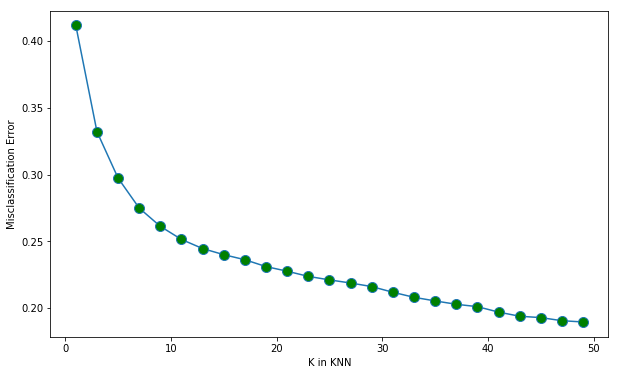

In [17]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 10-fold cross validation
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute', n_jobs=-1)
    scores = cross_val_score(knn, std_data_train, score_train, cv=10, scoring='roc_auc')
    cv_scores.append(scores.mean())
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
plt.figure(figsize=(10,6))
plt.xlabel('K in KNN')
plt.ylabel('Misclassification Error')
plt.plot(neighbors, MSE, marker='o',markerfacecolor='green', markersize=10)
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The accuracy of the knn classifier for k = 49 is 83.417740%


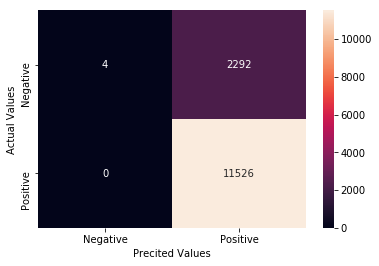

In [18]:
#learning the model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(std_data_train, score_train)

# predict on the test response
pred = knn_optimal.predict(std_data_test)

# evaluate accuracy on test data
acc = accuracy_score(score_test, pred) * 100

print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

cm = confusion_matrix(score_test, pred)
class_label = ['Negative', 'Positive']
conf_matrix = pd.DataFrame(cm, index=class_label, columns=class_label)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual Values')
plt.xlabel('Precited Values')
plt.show()


BOW(Kd Tree) 

In [19]:
count_vec = CountVectorizer()
bow_train_kd = count_vec.fit_transform(text_train_kd)
bow_test_kd = count_vec.transform(text_test_kd)

In [20]:
std_data_train_kd = MaxAbsScaler().fit_transform(bow_train_kd)
std_data_test_kd = MaxAbsScaler().fit_transform(bow_test_kd)
print(std_data_train_kd.shape)
print(std_data_test_kd.shape)

(14000, 13139)
(6000, 13139)


In [21]:
# Converting sparse matrix to dense matrix
svd = TruncatedSVD(n_components=400)
std_train_kd = svd.fit_transform(std_data_train_kd)
std_test_kd = svd.transform(std_data_test_kd)

In [22]:
print(std_train_kd.shape)
print(std_test_kd.shape)

(14000, 400)
(6000, 400)


100%|██████████| 25/25 [18:04<00:00, 43.19s/it]


The optimal number of neighbors is 49.


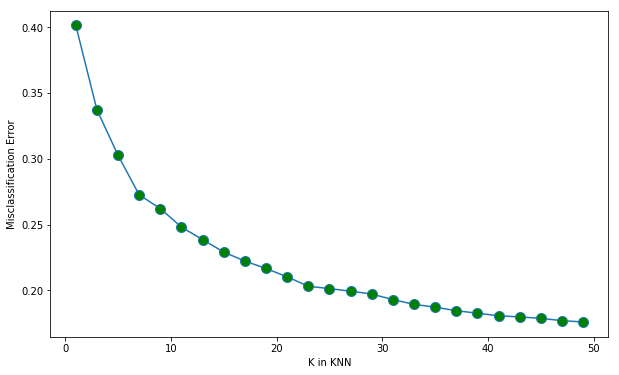

In [23]:
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 10-fold cross validation
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree', n_jobs=-1)
    scores = cross_val_score(knn, std_train_kd, score_train_kd, cv=5, scoring='roc_auc')
    cv_scores.append(scores.mean())
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
plt.figure(figsize=(10,6))
plt.xlabel('K in KNN')
plt.ylabel('Misclassification Error')
plt.plot(neighbors, MSE, marker='o',markerfacecolor='green', markersize=10)
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The accuracy of the knn classifier for k = 49 is 85.750000%


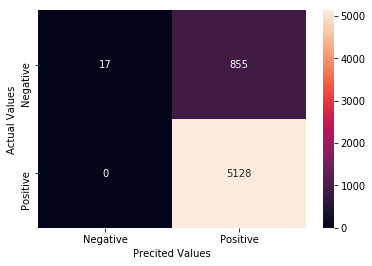

In [24]:
#learning the model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(std_train_kd, score_train_kd)

# predict on the test response
pred = knn_optimal.predict(std_test_kd)

# evaluate accuracy on test data
acc = accuracy_score(score_test_kd, pred) * 100

print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

cm = confusion_matrix(score_test_kd, pred)
class_label = ['Negative', 'Positive']
conf_matrix = pd.DataFrame(cm, index=class_label, columns=class_label)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual Values')
plt.xlabel('Precited Values')
plt.show()


[0.05441594 0.06507291 0.07518583 0.08441794 0.09324283 0.10172182
 0.10979264 0.11763786 0.12469015 0.13170914 0.13853149 0.14496861
 0.1513233  0.1576704  0.1639585  0.17006192 0.17597223 0.18173983
 0.18746536 0.19306584 0.19856422 0.20396899 0.20932946 0.21457541
 0.21979407 0.22489887 0.22995916 0.2349943  0.23998368 0.24491287
 0.2497348  0.25450393 0.25923458 0.26392355 0.26857048 0.27317335
 0.27774806 0.28226506 0.28674704 0.29121171 0.2956173  0.29999412
 0.30435442 0.30865666 0.31292847 0.31717706 0.32139928 0.32560881
 0.32980513 0.33395602 0.33808582 0.3421962  0.34626446 0.35031513
 0.35435883 0.35837927 0.36238667 0.36635898 0.37030777 0.37423988
 0.37813264 0.38201759 0.3858726  0.38970016 0.39351577 0.39731451
 0.4010982  0.40484854 0.40858749 0.41230325 0.41601769 0.41970792
 0.42338132 0.42704365 0.43068102 0.43431111 0.43791043 0.44150309
 0.44507779 0.44862754 0.45216215 0.45568474 0.45920405 0.46269053
 0.46615496 0.46961112 0.47304749 0.47648033 0.47989152 0.4832

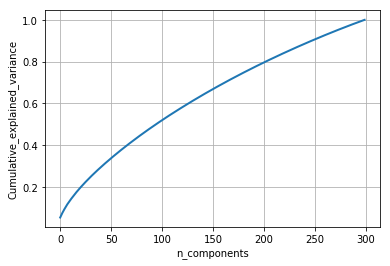

In [26]:
from sklearn import decomposition
pca = decomposition.PCA()
# PCA for dimensionality redcution (non-visualization)

pca.n_components = 300
pca_data = pca.fit_transform(std_train_kd)

# Calculating the cummulative sum of variances
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
cum_var = np.cumsum(percentage_var_explained)
print(cum_var)

# Plot the PCA spectrum
plt.plot(cum_var, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

# TFIDF

In [27]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2))

In [28]:
tfidf_train = tfidf_vect.fit_transform(text_train)
tfidf_test = tfidf_vect.transform(text_test)

In [29]:
#standardization of data
std_data_train = MaxAbsScaler().fit_transform(tfidf_train)
std_data_test = MaxAbsScaler().fit_transform(tfidf_test)
print(std_data_train.shape)
print(std_data_test.shape)

(32250, 435712)
(13822, 435712)


TFIDF(Brute Force)

100%|██████████| 25/25 [31:45<00:00, 76.21s/it]


The optimal number of neighbors is 29.


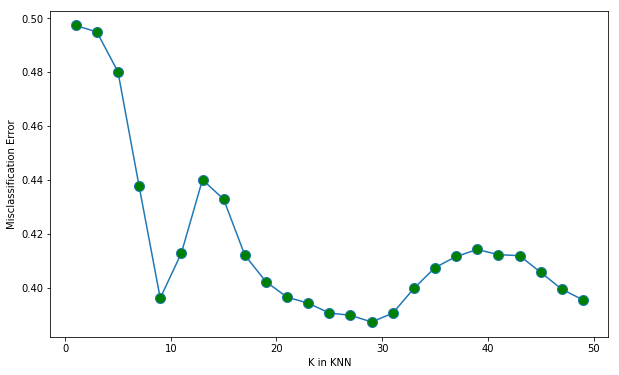

In [30]:
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 10-fold cross validation
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute', n_jobs=-1)
    scores = cross_val_score(knn, std_data_train, score_train, cv=10, scoring='roc_auc')
    cv_scores.append(scores.mean())
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
plt.figure(figsize=(10,6))
plt.xlabel('K in KNN')
plt.ylabel('Misclassification Error')
plt.plot(neighbors, MSE, marker='o',markerfacecolor='green', markersize=10)
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The accuracy of the knn classifier for k = 29 is 83.388800%


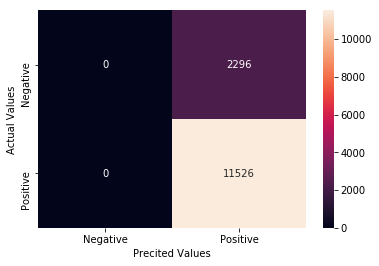

In [31]:
#learning the model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(std_data_train, score_train)

# predict on the test response
pred = knn_optimal.predict(std_data_test)

# evaluate accuracy on test data
acc = accuracy_score(score_test, pred) * 100

print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

cm = confusion_matrix(score_test, pred)
class_label = ['Negative', 'Positive']
conf_matrix = pd.DataFrame(cm, index=class_label, columns=class_label)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual Values')
plt.xlabel('Precited Values')
plt.show()

TFIDF(Kd tree)

In [32]:
tfidf_train_kd = tfidf_vect.fit_transform(text_train_kd)
tfidf_test_kd = tfidf_vect.transform(text_test_kd)

In [33]:
std_train_kd = MaxAbsScaler().fit_transform(tfidf_train_kd)
std_test_kd = MaxAbsScaler().fit_transform(tfidf_test_kd)

In [34]:
svd = TruncatedSVD(n_components=400)
std_train_kd = svd.fit_transform(std_train_kd)
std_test_kd = svd.transform(std_test_kd)

100%|██████████| 25/25 [17:42<00:00, 41.70s/it]



The optimal number of neighbors is 49.


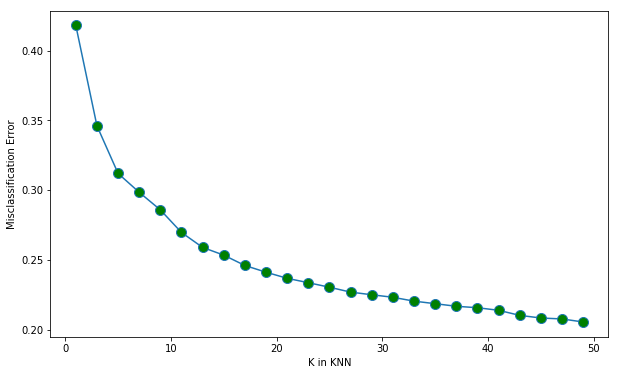

In [35]:
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 10-fold cross validation
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree', n_jobs=-1)
    scores = cross_val_score(knn, std_train_kd, score_train_kd, cv=5, scoring='roc_auc')
    cv_scores.append(scores.mean())
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
plt.figure(figsize=(10,6))
plt.xlabel('K in KNN')
plt.ylabel('Misclassification Error')
plt.plot(neighbors, MSE, marker='o',markerfacecolor='green', markersize=10)
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The accuracy of the knn classifier for k = 49 is 85.500000%


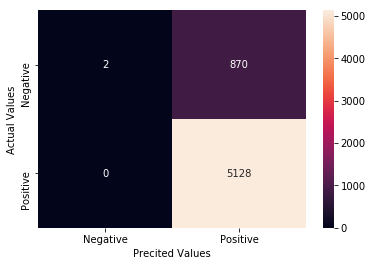

In [36]:
#learning the model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(std_train_kd, score_train_kd)

# predict on the test response
pred = knn_optimal.predict(std_test_kd)

# evaluate accuracy on test data
acc = accuracy_score(score_test_kd, pred) * 100

print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

cm = confusion_matrix(score_test_kd, pred)
class_label = ['Negative', 'Positive']
conf_matrix = pd.DataFrame(cm, index=class_label, columns=class_label)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual Values')
plt.xlabel('Precited Values')
plt.show()

[0.01548655 0.03056439 0.04252109 0.05400658 0.06427073 0.07299479
 0.0810848  0.08899008 0.09674921 0.10440736 0.11186325 0.11884
 0.12575818 0.13265203 0.13946356 0.14610043 0.15267345 0.15896809
 0.16521736 0.17130943 0.1771024  0.18280616 0.18844124 0.19402269
 0.19940397 0.20473504 0.20999268 0.21524656 0.2204521  0.22558409
 0.23067073 0.23571205 0.24074291 0.24570124 0.25063497 0.25552839
 0.2604     0.26523971 0.27003277 0.27480283 0.2795398  0.28418974
 0.28874419 0.29328196 0.29780187 0.30226015 0.30665951 0.31101161
 0.31531617 0.31959996 0.32386691 0.32803979 0.3322102  0.33633606
 0.3404378  0.34451297 0.34857022 0.35261796 0.35660332 0.36056558
 0.36450851 0.36842242 0.37230214 0.37617548 0.38003685 0.38388359
 0.38768032 0.39147378 0.39524369 0.39899397 0.40272886 0.40643168
 0.41012852 0.41380557 0.41747211 0.42111755 0.42473508 0.42834227
 0.43194523 0.43554228 0.4390887  0.44262895 0.44616137 0.44965609
 0.45312649 0.45659018 0.46003264 0.46346589 0.46689168 0.4703102

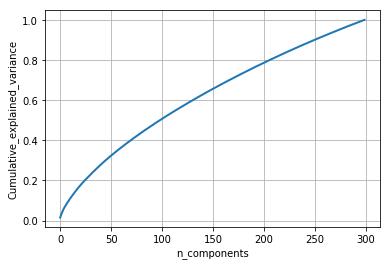

In [37]:
from sklearn import decomposition
pca = decomposition.PCA()
# PCA for dimensionality redcution (non-visualization)

pca.n_components = 300
pca_data = pca.fit_transform(std_train_kd)

# Calculating the cummulative sum of variances
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
cum_var = np.cumsum(percentage_var_explained)
print(cum_var)

# Plot the PCA spectrum
plt.plot(cum_var, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

# W2V and AvgW2V

In [38]:
#Splitting each sentence in to words
sent_words = []
for sent in Preproc_text:
    sent_words.append(sent.split())

In [39]:
#Converting each word into vector
from gensim.models import Word2Vec
w2v = Word2Vec(sent_words,min_count=5,size=50,workers=4)

In [40]:
#fining w2v_words
w2v_words = list(w2v.wv.vocab)

In [41]:
#Avg_W2V for all Reviews
avg_w2vs = []
for sent in tqdm(Preproc_text):
    #initializing number of words
    n_words = 0
    #initializing vector of size of 50
    sent_vec = np.zeros(50)
    for word in sent.split():
        if word in w2v_words:
            #creating for each word is an vector
            vec = w2v.wv[word]
            sent_vec += vec
            n_words += 1
    if n_words != 0:
        sent_vec /= n_words
        avg_w2vs.append(sent_vec)

100%|██████████| 46072/46072 [04:26<00:00, 172.96it/s]


In [42]:
text_train_avg, text_test_avg, score_train_avg, score_test_avg = train_test_split(avg_w2vs, score, test_size=0.3, 
                                                                  stratify=None, random_state=0)
avg_w2vs_kd = avg_w2vs[0:20000]
score_kd = score[0:20000]
text_train_avg_kd, text_test_avg_kd, score_train_avg_kd, score_test_avg_kd = train_test_split(avg_w2vs_kd, score_kd, test_size=0.3, 
                                                                  stratify=None, random_state=0)

In [43]:
#standardization of data for Burte force
std_train_avg = MaxAbsScaler().fit_transform(text_train_avg)
std_test_avg = MaxAbsScaler().fit_transform(text_test_avg)
print(std_train_avg.shape)
print(std_test_avg.shape)
print(score_train_avg.shape)
print(score_test_avg.shape)
#standardization of data for Kdtree
std_train_avg_kd = MaxAbsScaler().fit_transform(text_train_avg_kd)
std_test_avg_kd = MaxAbsScaler().fit_transform(text_test_avg_kd)
print(std_train_avg_kd.shape)
print(std_test_avg_kd.shape)

(32250, 50)
(13822, 50)
(32250,)
(13822,)
(14000, 50)
(6000, 50)


AVGW2V(Brute Force)

100%|██████████| 25/25 [26:00<00:00, 62.50s/it]


The optimal number of neighbors is 49.


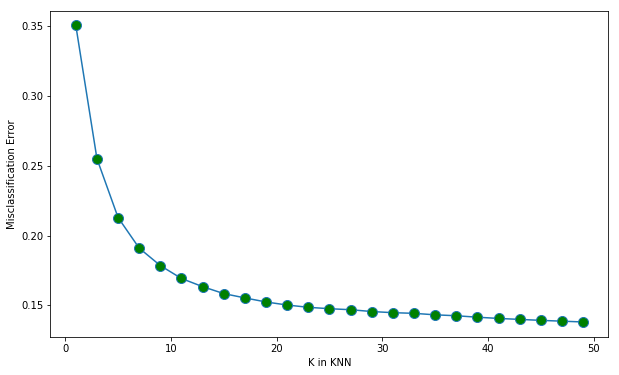

In [44]:
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 10-fold cross validation
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute', n_jobs=-1)
    scores = cross_val_score(knn, std_train_avg, score_train_avg, cv=10, scoring='roc_auc')
    cv_scores.append(scores.mean())
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
plt.figure(figsize=(10,6))
plt.xlabel('K in KNN')
plt.ylabel('Misclassification Error')
plt.plot(neighbors, MSE, marker='o',markerfacecolor='green', markersize=10)
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The accuracy of the knn classifier for k = 49 is 85.696715%


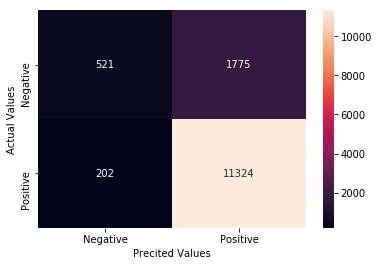

In [45]:
#learning the model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(std_train_avg, score_train_avg)

# predict on the test response
pred = knn_optimal.predict(std_test_avg)

# evaluate accuracy on test data
acc = accuracy_score(score_test_avg, pred) * 100

print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

cm = confusion_matrix(score_test_avg, pred)
class_label = ['Negative', 'Positive']
conf_matrix = pd.DataFrame(cm, index=class_label, columns=class_label)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual Values')
plt.xlabel('Precited Values')
plt.show()

AVGW2V(Kd Tree)

In [46]:
#svd = TruncatedSVD(n_components=300)
#std_train_avg_kd = svd.fit_transform(std_train_avg_kd)
#std_test_avg_kd = svd.transform(std_test_avg_kd)

100%|██████████| 25/25 [03:01<00:00,  7.17s/it]


The optimal number of neighbors is 49.


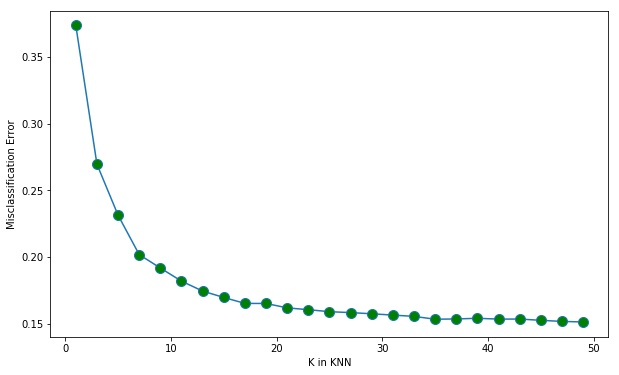

In [47]:
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 10-fold cross validation
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree', n_jobs=-1)
    scores = cross_val_score(knn, std_train_avg_kd, score_train_avg_kd, cv=5, scoring='roc_auc')
    cv_scores.append(scores.mean())
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
plt.figure(figsize=(10,6))
plt.xlabel('K in KNN')
plt.ylabel('Misclassification Error')
plt.plot(neighbors, MSE, marker='o',markerfacecolor='green', markersize=10)
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The accuracy of the knn classifier for k = 49 is 87.050000%


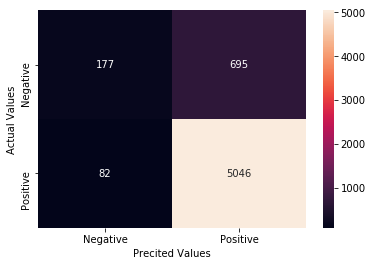

In [48]:
#learning the model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(std_train_avg_kd, score_train_avg_kd)

# predict on the test response
pred = knn_optimal.predict(std_test_avg_kd)

# evaluate accuracy on test data
acc = accuracy_score(score_test_avg_kd, pred) * 100

print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

cm = confusion_matrix(score_test_avg_kd, pred)
class_label = ['Negative', 'Positive']
conf_matrix = pd.DataFrame(cm, index=class_label, columns=class_label)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual Values')
plt.xlabel('Precited Values')
plt.show()

# Tfidf and W2V

In [49]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df = 10, max_features = 500)
tfidf = tfidf_vect.fit_transform(Preproc_text)
print(len(Preproc_text))

46072


In [50]:
from IPython.display import clear_output
from tqdm import tqdm
features = tfidf_vect.get_feature_names()
tfidf_w2vs = []
row = 0
for sent in tqdm(Preproc_text):
    clear_output(wait=True)
    sent_vec = np.zeros(50)
    tfidf_sum = 0
    for word in sent.split():
        if(word in w2v_words) and word in features:
            vec = w2v.wv[word]
            tfidf_value = tfidf[row, features.index(word)]
            sent_vec += (vec * tfidf_value)
            tfidf_sum += tfidf_value
#    if(tfidf_sum != 0):
    sent_vec /= tfidf_sum
    tfidf_w2vs.append(sent_vec)
#    row += 1
    pass

100%|██████████| 46072/46072 [07:53<00:00, 97.23it/s] 


In [51]:
tfidf_w2vs = np.nan_to_num(tfidf_w2vs)
score = np.nan_to_num(score)
text_train_w2v, text_test_w2v, score_train_w2v, score_test_w2v = train_test_split(tfidf_w2vs, score, test_size=0.3, 
                                                                  stratify=None, random_state=0)
tfidf_w2vs_kd = tfidf_w2vs[0:20000]
score_w2v_kd = score[0:20000]
text_train_w2v_kd, text_test_w2v_kd, score_train_w2v_kd, score_test_w2v_kd = train_test_split(tfidf_w2vs_kd, score_w2v_kd, test_size=0.3, 
                                                                  stratify=None, random_state=0)

In [52]:
#standardization of data
std_train_w2v = MaxAbsScaler().fit_transform(text_train_w2v)
std_test_w2v = MaxAbsScaler().fit_transform(text_test_w2v)
print(std_train_w2v.shape)
print(std_test_w2v.shape)

(32250, 50)
(13822, 50)


TFIDFW2V(Brute Force)

100%|██████████| 25/25 [26:26<00:00, 64.19s/it]


The optimal number of neighbors is 43.


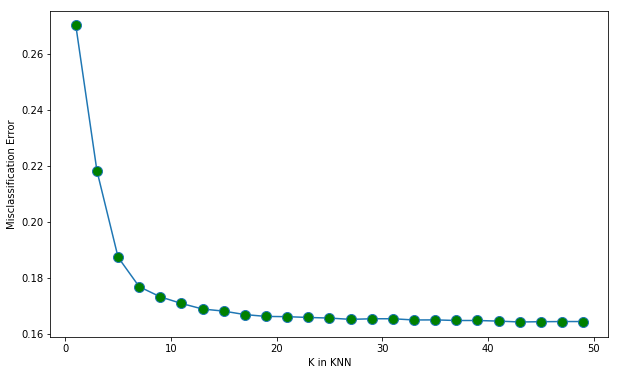

In [53]:
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 10-fold cross validation
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute', n_jobs=-1)
    scores = cross_val_score(knn, std_train_w2v, score_train_w2v, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
plt.figure(figsize=(10,6))
plt.xlabel('K in KNN')
plt.ylabel('Misclassification Error')
plt.plot(neighbors, MSE, marker='o',markerfacecolor='green', markersize=10)
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The accuracy of the knn classifier for k = 43 is 83.446679%


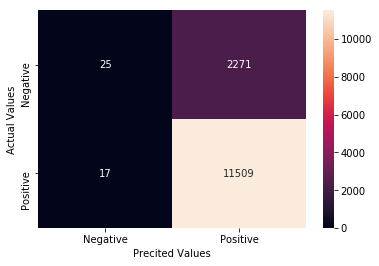

In [54]:
#learning the model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(std_train_w2v, score_train_w2v)

# predict on the test response
pred = knn_optimal.predict(std_test_w2v)

# evaluate accuracy on test data
acc = accuracy_score(score_test_w2v, pred) * 100

print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

cm = confusion_matrix(score_test_w2v, pred)
class_label = ['Negative', 'Positive']
conf_matrix = pd.DataFrame(cm, index=class_label, columns=class_label)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual Values')
plt.xlabel('Precited Values')
plt.show()

TFIDFW2V(Kd Tree)

In [55]:
std_train_w2v_kd = MaxAbsScaler().fit_transform(text_train_w2v_kd)
std_test_w2v_kd = MaxAbsScaler().fit_transform(text_test_w2v_kd)


The optimal number of neighbors is 49.


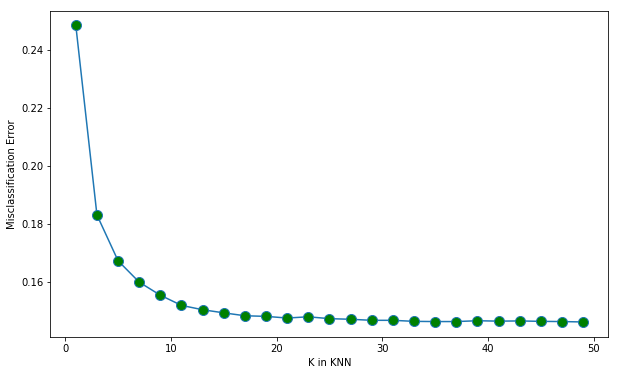

In [56]:
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree', n_jobs=-1)
    scores = cross_val_score(knn, std_train_w2v_kd, score_train_w2v_kd, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
plt.figure(figsize=(10,6))
plt.xlabel('K in KNN')
plt.ylabel('Misclassification Error')
plt.plot(neighbors, MSE, marker='o',markerfacecolor='green', markersize=10)
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The accuracy of the knn classifier for k = 49 is 85.450000%


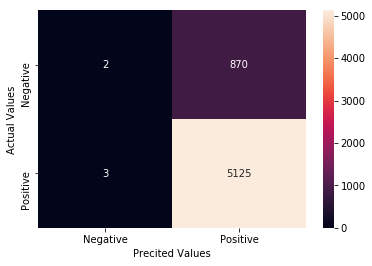

In [57]:
#learning the model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(std_train_w2v_kd, score_train_w2v_kd)

# predict on the test response
pred = knn_optimal.predict(std_test_w2v_kd)

# evaluate accuracy on test data
acc = accuracy_score(score_test_w2v_kd, pred) * 100

print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

cm = confusion_matrix(score_test_w2v_kd, pred)
class_label = ['Negative', 'Positive']
conf_matrix = pd.DataFrame(cm, index=class_label, columns=class_label)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual Values')
plt.xlabel('Precited Values')
plt.show()

## Conclusion

In [3]:
from IPython.display import HTML, display
import tabulate
table = [["S.NO.","MODEL || KNN ||","Best K","Test Accuracy"],
         ["1","BOW | brute |","49","83.4177"],
         ["2","BOW | kd_tree |","49","85.7500"],
         ["3","TF-IDF | brute |","29","83.3888"],
         ["4","TF-IDF | kd_tree |","49","85.0000"],
         ["5","AVG W2VEC | brute |","49","85.6967"],
         ["6","AVG W2VEC | kd_tree |","49","87.0500"],
         ["7","TF-IDF W2VEC | brute |","43","83.4466"],
         ["8","TF-IDF W2VEC | kd_tree |","49","85.4500"]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

S.NO.,MODEL || KNN ||,Best K,Test Accuracy
1,BOW | brute |,49,83.4177
2,BOW | kd_tree |,49,85.7500
3,TF-IDF | brute |,29,83.3888
4,TF-IDF | kd_tree |,49,85.0000
5,AVG W2VEC | brute |,49,85.6967
6,AVG W2VEC | kd_tree |,49,87.0500
7,TF-IDF W2VEC | brute |,43,83.4466
8,TF-IDF W2VEC | kd_tree |,49,85.4500
